# Training SimpleNN on CIFAR-10
In this project, you will use the SimpleNN model to perform image classification on CIFAR-10. CIFAR-10 orginally contains 60K images from 10 categories. We split it into 45K/5K/10K images to serve as train/valiation/test set. We only release the ground-truth labels of training/validation dataset to you.

## Step 0: Set up the SimpleNN model
As you have practiced to implement simple neural networks in Homework 1, we just prepare the implementation for you.

In [1]:
# import necessary dependencies
import argparse
import os, sys
import pickle
import time
import datetime
from tqdm import tqdm_notebook as tqdm
import copy
import numpy as np
import random
import torchvision
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from models import ResNet20, CNNCifar
from datasplit import cifar_iid, cifar_noniid, cifar_noniid_simple, cifar_noniid_simple2, cifar_noniid_simple3
from FL import LocalUpdate, average_weights
from record import save_variable, load_variable

# from torchtoolbox.transform import Cutout
from tools.dataset import CIFAR10
from torch.utils.data import DataLoader,Dataset

## Some preparation before training

In [2]:
#############################################
# specify preprocessing function
transform_train = transforms.Compose([
    
    transforms.RandomCrop(32,4),
#     Cutout(0.5),
    transforms.RandomHorizontalFlip(),        
   # transforms.RandomRotation(5),
   # transforms.RandomGrayscale(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),    
]) 

transform_val =  transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),(0.2023, 0.1994, 0.2010)),    
])
#############################################

In [3]:
# do NOT change these
# a few arguments, do NOT change these
DATA_ROOT = "./data"
TRAIN_BATCH_SIZE = 128
VAL_BATCH_SIZE = 100

#############################################
# construct dataset
train_set = CIFAR10(
    root=DATA_ROOT, 
    mode='train', 
    download=True,
    transform=transform_train    # your code
)
val_set = CIFAR10(
    root=DATA_ROOT, 
    mode='val', 
    download=True,
    transform=transform_val    # your code
)

val_loader = DataLoader(
    val_set, 
    batch_size= VAL_BATCH_SIZE,  # your code
    shuffle=False,     # your code
    num_workers=4
)
#############################################

Using downloaded and verified file: ./data/cifar10_trainval_F21.zip
Extracting ./data/cifar10_trainval_F21.zip to ./data
Files already downloaded and verified
Using downloaded and verified file: ./data/cifar10_trainval_F21.zip
Extracting ./data/cifar10_trainval_F21.zip to ./data
Files already downloaded and verified


In [4]:
# specify the device for computation
#############################################
# your code here
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# global_net = ResNet20(Block)
global_net = CNNCifar()
global_net.to(device)
#############################################
criterion = nn.CrossEntropyLoss().to(device)

### Standard Federated Training

In [5]:
# some hyperparameters
# total number of training epochs
EPOCHS = 50
C = 0.1
K = 100

# the folder where the trained model is saved
CHECKPOINT_PATH = "./saved_model"

###########   Use different type of Data :    IID, NON-IID (unbalanced/ 1 CLASS/ 2 CLASS/ 3 CLASS)  ##########
# user_groups = cifar_iid(train_set, 10)
#user_groups = cifar_noniid(train_set, K)
# user_groups = cifar_noniid_simple(train_set, K)
user_groups = cifar_noniid_simple2(train_set, K)
# user_groups = cifar_noniid_simple3(train_set, K)
######################################################################

# start the training/validation process
best_val_acc = 0
current_learning_rate = 0.01
print("==> Training starts!")
print("="*50)

train_loss, train_accuracy = [], []
Validation_acc_global = []

##############  Initialize all the clients model, for later randomly pick up  #################
client_models = {i: CNNCifar().to(device) for i in range(K)}

##############  Training begins   ##############
for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    local_weights, local_losses = [], []
    print(f'\n | Global Training Round : {i+1} |\n')
    #######################
    # switch to train mode
    global_net.train()
    print("Epoch %d:" %(i+1))
     
    ######## m is the number of clients, C is the ration and K is the total number of candidate.
    m = int(max(C*K,1))
    
    ######## randomly pick m clients from K candidate
    List111 = []
    [List111.append(i) for i in range (K)]
    random.shuffle(List111)
    List1 = []
    for i in range(m):
        List1.append(List111[i])
    ##################################################
#     List1=[]
#     [List1.append(i) for i in range(m)]
#     random.shuffle(List1)
    ####################### 
    """
    Allocate ids to the client and use ids to call the corresponding client model
    When use the model: 1. Initialization       2. Each client will return weight and loss 
                        3. Use agggregation to get the global weight    4. Use state_dict to update weight
    """
    global_weights = global_net.state_dict()
    
    local_model = {i: LocalUpdate(dataset=train_set,idxs=user_groups[i],Gweight = global_weights) for i in List111}
    #     local_model = LocalUpdate(dataset=train_set,idxs=user_groups,Gweight = global_weights)
    """
    For later attack, we can appoint the ids to attack the local model
    for example:   directly change the data & model
    """   
#     for idx in List1:
    for idx in List1:
        ################## For client[idx], can do poisoning attack here   ######################
        w, loss = local_model[idx].update_weights(model=client_models[idx], Gweight = global_weights)
#         w, loss = local_model[idx].update_weights_prox(model=client_models[idx], global_net= global_net,Gweight = global_weights,mu = 0.00001)
        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))

        # update global weights
    global_weights = average_weights(local_weights)

        # update global weights
    global_net.load_state_dict(global_weights)
    
    loss_avg = sum(local_losses) / len(local_losses)
    train_loss.append(loss_avg)
    
    global_net.eval()
    list_acc, list_loss = [], []
    
    ######### check training loss and training accuracy #########
    for c in range(K):
        local_model = LocalUpdate(dataset=train_set,idxs=user_groups[idx],Gweight = None)
        acc, loss = local_model.inference(model=global_net)
        list_acc.append(acc)
        list_loss.append(loss)
        train_accuracy.append(sum(list_acc)/len(list_acc))
    print(f' \nAvg Training Stats after {i+1} global rounds:')
    print(f'Training Loss : {np.mean(np.array(train_loss))}')
    print('Train Accuracy: {:.2f}% \n'.format(100*train_accuracy[-1]))

    # Validate on the validation dataset
    #######################
    # switch to eval mode
    global_net.eval()  
    #######################

    # this help you compute the validation accuracy
    total_examples = 0
    correct_examples = 0
    
    val_loss = 0 # again, track the validation loss if you want

    # disable gradient during validation, which can save GPU memory
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(val_loader):
            ####################################
            # your code here
            # copy inputs to device
            inputs = inputs.to(device)
            #targets = torch.Tensor(targets).long()
            targets = targets.to(device)
            # compute the output and loss
            outputs = global_net(inputs)        
            loss = criterion(outputs, targets.long())
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs, 1)
            correct = predicted.eq(targets).sum()
            ##############
            total_examples+=targets.shape[0]
            correct_examples+=correct.item()
            val_loss+=loss
            ####################################

    avg_loss = val_loss / len(val_loader)
    avg_acc = correct_examples / total_examples
    print("Validation loss: %.4f, Validation accuracy: %.4f" % (avg_loss, avg_acc))
    Validation_acc_global.append(avg_acc)
    filename = save_variable(Validation_acc_global,'accuracy4.txt')
    # save the model checkpoint
    if avg_acc > best_val_acc:
        best_val_acc = avg_acc
        if not os.path.exists(CHECKPOINT_PATH):
            os.makedirs(CHECKPOINT_PATH)
        print("Saving ...")
        state = {'state_dict': global_net.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_PATH, 'Simplenn.pth'))
        
    print('')
    
print("="*50)
print(f"==> Optimization finished! Best validation accuracy: {best_val_acc:.4f}")


==> Training starts!

 | Global Training Round : 1 |

Epoch 1:


/home/jovyan/work/FL.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(inputs), torch.tensor(targets)


KeyboardInterrupt: 

In [10]:
filename = save_variable(Validation_acc_global,'Record_name.txt')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(EPOCHS),Validation_acc_global,label='Record_name')
ax.set_title('Federated Learning with K clients')
ax.set_xlabel('Communication Round')
ax.set_ylabel('Test Accuracy')
plt.legend(frameon=False,loc="lower right")
plt.show

In [11]:
rrr = load_variable('Record_name.txt')

<function matplotlib.pyplot.show(*args, **kw)>

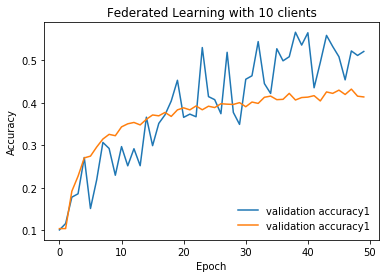

In [13]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(EPOCHS),rrr,label='validation accuracy1')
ax.set_title('Federated Learning with K clients')
ax.set_xlabel('Communication Round')
ax.set_ylabel('Test Accuracy')
plt.legend(frameon=False,loc="lower right")
plt.show